In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

In [2]:
iris = load_iris()
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                         columns= iris['feature_names'] + ['target'])
cls_names = iris.target_names

In [3]:
def compute_class_stats(X, y):
    cls_labels = np.unique(y)
    n_cls = cls_labels.shape[0]
    means = np.empty((n_cls, 1))
    stds = np.empty((n_cls, 1))
    
    for i, cls in enumerate(cls_labels):
        idxs = np.where(y == cls)
        X_cls = X[idxs]
        mean = X_cls.mean()
        sigma = X_cls.std()
        means[i] = mean
        stds[i] = sigma
        
    return means, stds

def calc_priors(y):
    priors = []
    n_examples = y.shape[0]
    for cls in np.unique(y):
        p = len(np.where(y == cls)[0]) / n_examples
        priors.append(p)
    return priors
        
def evaluate_gaussian(x, mu, sigma):
    p = stats.norm.pdf(x, mu, sigma)
    return p


def plot_gaussians(means, stds, cls_names, point=None):
    x = np.linspace(-1,10, 100).reshape(100, -1)
    colors = ['r', 'g', 'b']
    for i in range(means.shape[0]):
        mu = means[i]
        sigma = stds[i]
        plt.plot(x, evaluate_gaussian(x, mu, sigma), 
                 label=cls_names[i], color=colors[i])
        if(point):
            y = evaluate_gaussian(point, mu, sigma)
            plt.scatter(x=point, y=y, color=colors[i])
            
    plt.legend()
    plt.show()

In [4]:
X = iris_df["petal length (cm)"]
y = iris_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
means, stds = compute_class_stats(X_train.to_numpy(), y_train)

for i in range(means.shape[0]):
    print(f"Mean and sigma of class {cls_names[i]} = {means[i]}, {stds[i]}")

Mean and sigma of class setosa = [1.45405405], [0.14064445]
Mean and sigma of class versicolor = [4.19117647], [0.47052389]
Mean and sigma of class virginica = [5.58292683], [0.55211453]


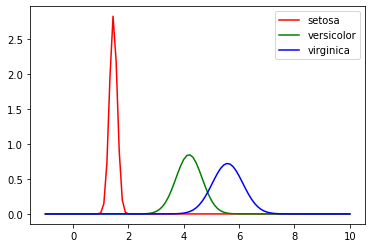

In [6]:
plot_gaussians(means, stds, cls_names)

# Calculate and Visualize Priors

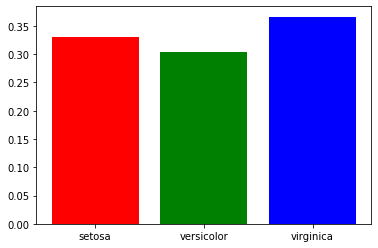

In [7]:
priors = calc_priors(y_train)
plt.bar(cls_names, priors, color=['r', 'g', 'b']);

# Maximum Likelihood

Maximum Likelihood Estimator computes how likely our observation is, given a hypothesis. It does not take into consideration the prior probiabilities (how likely these classes are to occur in our data). Mathematically, this is computed as:
$$P(x| C_j)$$

where X is the feature value and C is the class (hypothesis).

In [8]:
def predict_MLE(X, means, stds, n_cls):
    likelihoods = np.empty((X.shape[0], n_cls))
    for i in range(X.shape[0]):
        for j in range(n_cls):
            mu, sigma = means[j], stds[j]
            l = evaluate_gaussian(X[i], mu, sigma)
            likelihoods[i, j] = l
    preds = np.argmax(likelihoods, axis=1)
    return preds

def plot_likelihood(x, means, stds, n_cls=3):
    plot_gaussians(means, stds, cls_names, x)

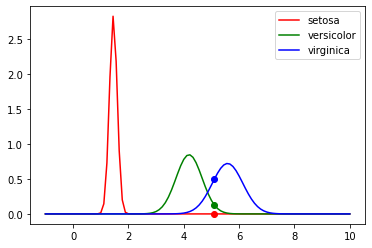

In [9]:
plot_likelihood(X_test.iloc[0], means, stds, cls_names)

In [10]:
MLE_preds = predict_MLE(X_test.to_numpy(), means, stds, n_cls=3)
MLE_accuracy = accuracy_score(y_test, MLE_preds)
print(MLE_accuracy)

0.9473684210526315


In [11]:
confusion_matrix(y_test, MLE_preds)

array([[13,  0,  0],
       [ 0, 15,  1],
       [ 0,  1,  8]], dtype=int64)

# Bayesian A Posteriori

Bayesian A Posteriori approach evaluates the probability of each class (hypotheesis) given a measurement. Mathematically, this is defined as follows:
                            $$P(C_j|x) =\frac{P(x | C_j)}{P(x)}$$

To make a prediction, we choose the class associated with the maximum posterior probability.

In [12]:
def compute_posteriors(X, priors, means, stds, n_cls):
    n_points = X.shape[0]
    posteriors = np.empty((n_points, n_cls))
    for i in range(n_points):
        for j in range(n_cls):
            mu, sigma = means[j], stds[j]
            likelihood = evaluate_gaussian(X[i], mu, sigma)
            posteriors[i, j] = likelihood * priors[j]
    posteriors = normalize(posteriors, axis=1, norm='l1')
    return posteriors

def predict_bayesian_posterior(X, priors, means, stds, n_cls):
    posteriors = compute_posteriors(X, priors, means, stds, n_cls)
    preds = np.argmax(posteriors, axis=1)
    return preds

def plot_posteriors(priors, means, stds, n_cls, cls_names):
    x = np.linspace(-1,10, 100).reshape(100, -1)
    posteriors = compute_posteriors(x, priors, means, stds, n_cls)
    colors = ['r', 'g', 'b']
    for i in range(n_cls):
        y = posteriors[:, i]
        plt.plot(x, y, colors[i],label=cls_names[i])
    plt.legend()

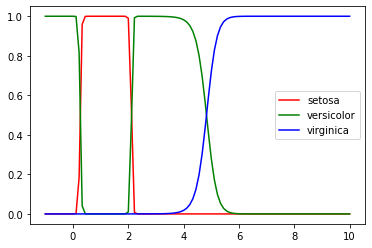

In [13]:
plot_posteriors(priors, means, stds, 3, cls_names)

In [14]:
bayesian_preds = predict_bayesian_posterior(X_test.to_numpy(), priors, means, stds, 3)
accuracy_score(y_test, bayesian_preds)

0.9473684210526315

In [15]:
confusion_matrix(y_test, bayesian_preds)

array([[13,  0,  0],
       [ 0, 15,  1],
       [ 0,  1,  8]], dtype=int64)

# Risk Based Bayesian Decision Theory Classifier

RBDTC does the same thing as Bayesian A Posteriori classifier, but it allows associating risks with classifications. In some situations where some mistakes are more costly than others, we can provide lower risks to safer predictions, so that we don't predict certain classes unless their posterior probabilities are really high. The risk is computed as shown below, and the class that minimizes this risk is chosen.

$$R(\alpha_i | x)=\sum_{j=0}^n \lambda_{ij}P(C_j|x)$$ where n is the number of classes and lambda is the risk matrix.

In [16]:
def predict_RBDTC(risk_mat, X, priors, means, stds, n_cls):
    posteriors = compute_posteriors(X, priors, means, stds, n_cls)
    probList = [(posteriors * risk_mat[i]).sum(axis=1).reshape((-1, 1))
                    for i in range(n_cls)]
    prob = np.hstack(probList)
    preds = np.argmin(prob, axis=1)
    return preds

In [17]:
risk_mat = np.array([[-10, -1, -1],
                       [-1, -10, -1],
                       [-1, -1, -10]])

RBDTC_preds = predict_RBDTC(risk_mat, X_test.to_numpy(), priors, means, stds, 3)

In [18]:
print(accuracy_score(y_test, RBDTC_preds))

0.9473684210526315


In [19]:
confusion_matrix(y_test, RBDTC_preds)

array([[13,  0,  0],
       [ 0, 15,  1],
       [ 0,  1,  8]], dtype=int64)

Above, we supplied a risk matrix where similar risk is assigned to each class. To favor a certain class over others (consider a bank giving loan to a client, not granting the loan is definitely less costly than granting it to someone who may not repay), we can assign a lower risk to it. Below, we assign risk of -100 instead of -10 to class 3, and see how this affects the confusion matrix. Although this reduces the overall accuracy, it led to more points being classified as class 3 and less as class 2.

In [20]:
risk_mat = np.array([[-10, -1, -1],
                       [-1, -10, -1],
                       [-1, -1, -100]])

RBDTC_preds = predict_RBDTC(risk_mat, X_test.to_numpy(), priors, means, stds, 3)
print(accuracy_score(y_test, RBDTC_preds))
confusion_matrix(y_test, RBDTC_preds)

0.7105263157894737


array([[13,  0,  0],
       [ 0,  5, 11],
       [ 0,  0,  9]], dtype=int64)